# Load raw dataset

In [1]:
import pickle
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# data
zenith = 20  # 'random'
table = 'regressor_5sgm_exp30m_z20_xy_flip.pickle'
path = f'/data01/homes/dipiano/E4/irf_z{zenith}/crab/'
dataset = join(path, table)

# dataset 
if '.pickle' in table:
    with open(dataset,'rb') as f: ds = pickle.load(f)
    infotable = join(path, table.replace('.pickle', '.dat'))
elif '.npy' in table:
    ds = np.load(dataset, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
    infotable = join(path, table.replace('.npy', '.dat'))
    
ds = np.array(ds['DS'])
ds = ds.reshape(ds.shape[0], ds.shape[1], ds.shape[2], 1)
ds.shape

(20000, 200, 200, 1)

# Infotable

In [2]:
infodata = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
infodata.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
14000,crab_00001,1,0,100,100,316.641513,12.589385,316.529421,12.904256,0.333312,North_z20_S_0.5h_LST,2.5,6.472037
14001,crab_00002,2,0,100,100,16.841739,78.034907,18.877416,77.993683,0.424728,North_z20_0.5h_LST,2.5,6.277098
14002,crab_00003,3,0,100,100,340.483309,-17.472847,340.130408,-17.623667,0.368734,North_z20_S_0.5h_LST,2.5,6.194221
14003,crab_00004,4,0,100,100,344.849066,86.535858,329.619289,84.942323,1.941093,North_z20_N_0.5h_LST,2.5,6.153547
14004,crab_00005,5,0,100,100,214.863376,34.357314,216.119150,33.122741,1.616953,North_z20_N_0.5h_LST,2.5,6.129901


# Pick seed

In [3]:
idx = np.random.choice(range(len(ds)))
idx = 16239
# find seed to get the original heatmap
seed = idx + 1
print(seed)

16240


In [4]:
row = infodata[infodata['seed']==seed]
row

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
2239,crab_16240,16240,0,100,100,146.066754,54.134003,147.112878,53.504078,0.882134,North_z20_0.5h_LST,2.5,6.141158


# Set WCS

In [5]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

# Denoise dataset

In [6]:
import tensorflow as tf

root = '/data01/homes/dipiano/astroAI/astroai/'
cnnname = 'cleaner_FINAL_5sgm_filter12_exp30m_z20'
model = tf.keras.models.load_model(join(root, 'models/cnn_cleaner', f'{cnnname}.keras'))
predictions = model.predict(ds)

2024-03-22 14:58:00.397496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 14:58:02.192702: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 14:58:13.965022: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-22 14:58:13.973062: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

625/625 [==============================] - 15s 23ms/step


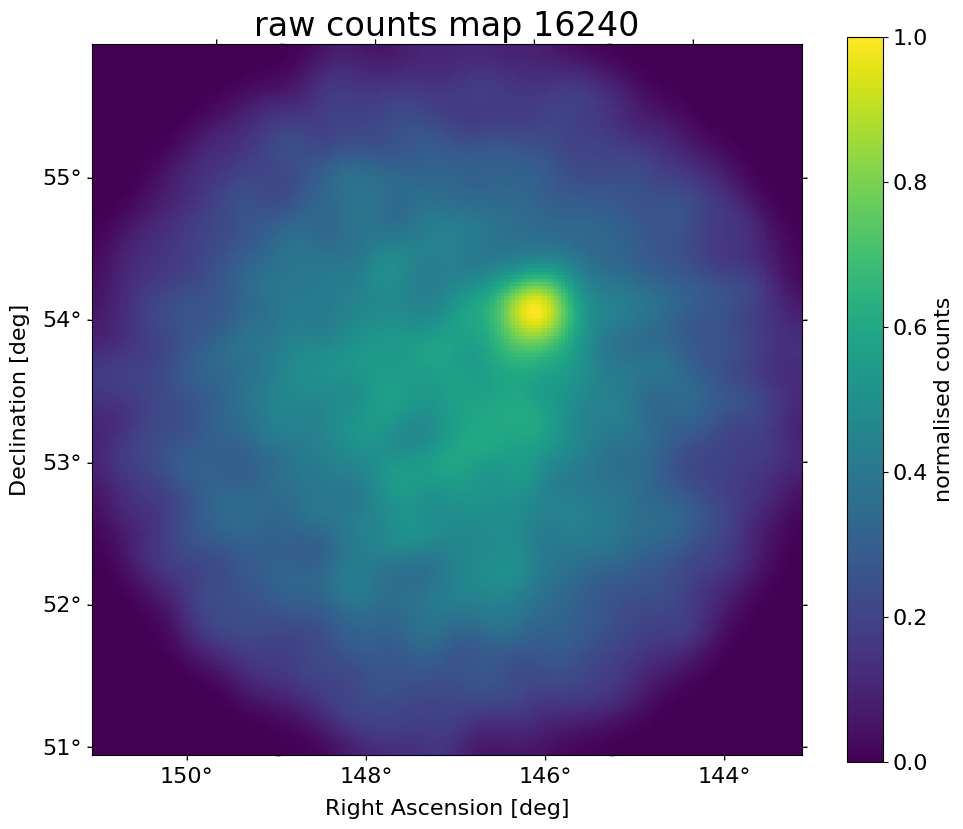

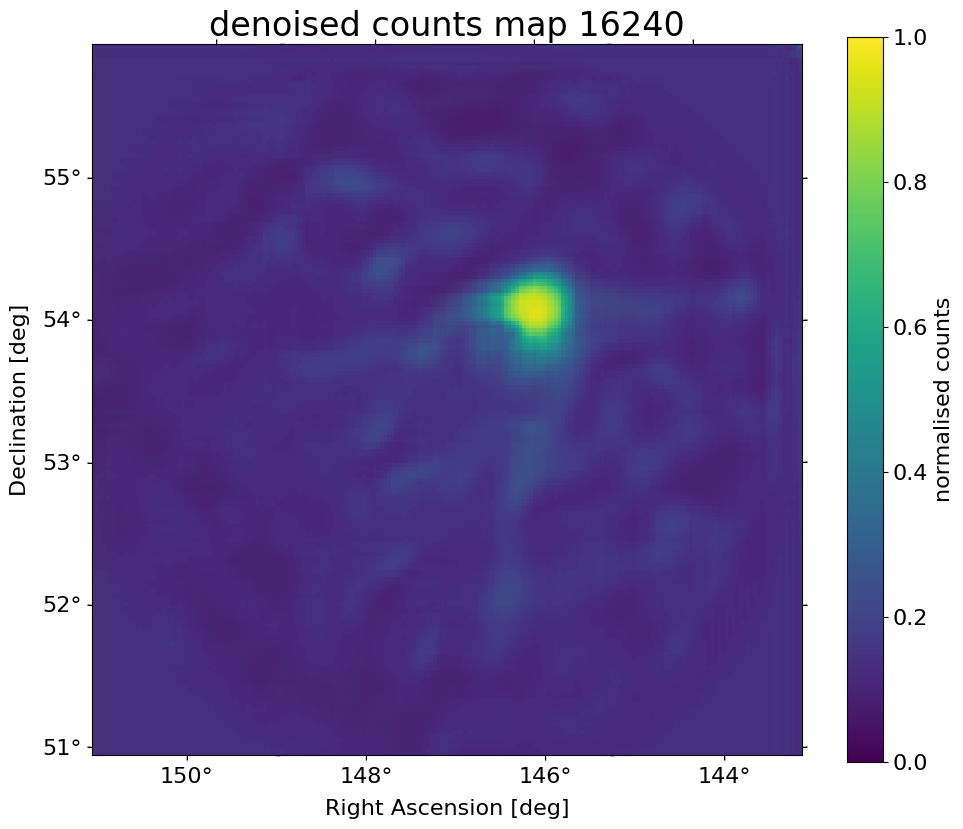

In [19]:
import astropy.units as u
from matplotlib.lines import Line2D

radius_deg = 0.2
radius_pix = radius_deg/0.025
figsize = (10, 10)
fs = 16

# NOISY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
    
img = ax.imshow(ds[idx], vmin=0, vmax=1)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
ax.set_title(f'raw counts map {seed}', fontsize=fs*1.5)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.tight_layout()
plt.show()

# CLEAN
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
img = ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
ax.set_title(f'denoised counts map {seed}', fontsize=fs*1.5)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)

plt.tight_layout()
plt.show()

In [20]:
# save plot
fig.savefig(f'img/heatmap_{seed}_noisy.png')
fig.savefig(f'img/heatmap_{seed}_clean.png')

# Localise candidates

In [21]:
import tensorflow as tf

savename = 'regressor_FINAL_5sgm_filter6_4convs_z20_xy_flip' 
model = tf.keras.models.load_model(f'../models/cnn_regressor/{savename}.keras')
candidates = model.predict(predictions) * binning

625/625 [==============================] - 25s 38ms/step


In [22]:
from astroai.tools.utils import *

binning = 200
pixelsize = (2 * row['fov'].values[0]) / binning
point_ref = (binning / 2) + (pixelsize / 2)
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=point_ref, pixelsize=pixelsize)

# TRUE
true_sky = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')
x, y = w.world_to_pixel(true_sky) 
true_sky = true_sky.ra.deg, true_sky.dec.deg
true_pix = x, y

# PREDICTION
pred_pix = candidates[idx]
sky = w.pixel_to_world(pred_pix[0], pred_pix[1])
pred_sky = sky.ra.deg, sky.dec.deg


print(f'SEED: {seed}')
print('---- PIX')
print(f"true: {true_pix}")
print(f"prediction: {pred_pix}")
print('---- SKY')
print(f"true: {true_sky} ")
print(f"prediction: {pred_sky}")

SEED: 16240
---- PIX
true: (array(123.5422246), array(124.40192234))
prediction: [123.19592 124.30865]
---- SKY
true: (146.06675404989076, 54.13400294047054) 
prediction: (146.0815858890918, 54.13179747493052)


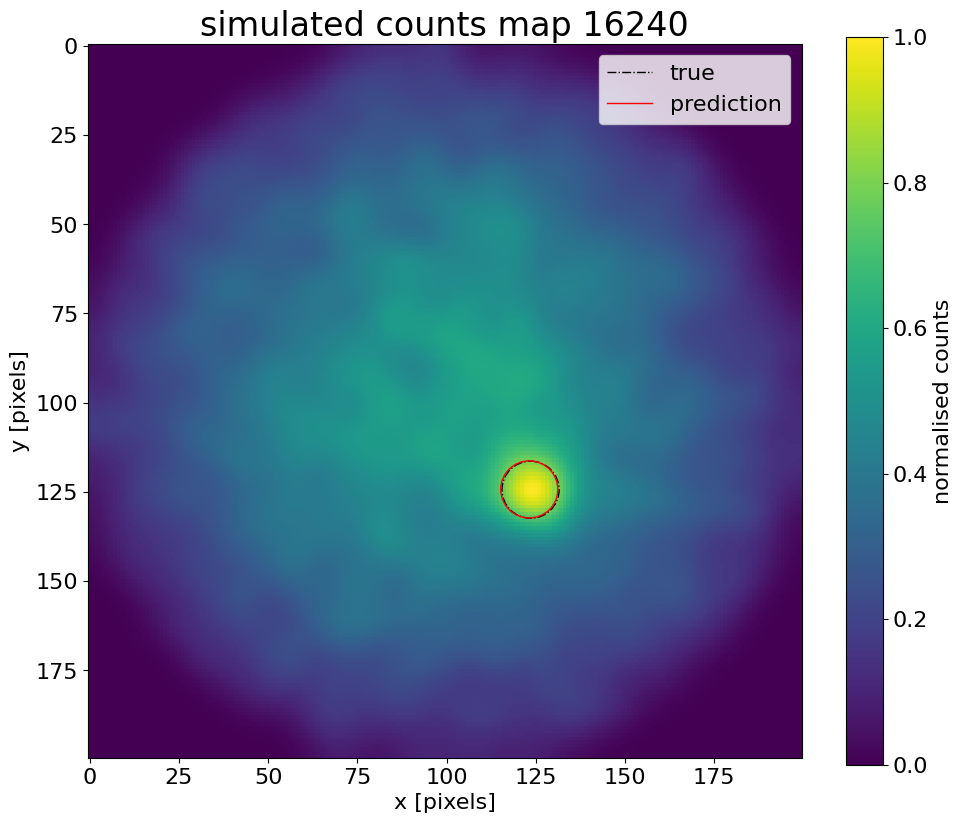

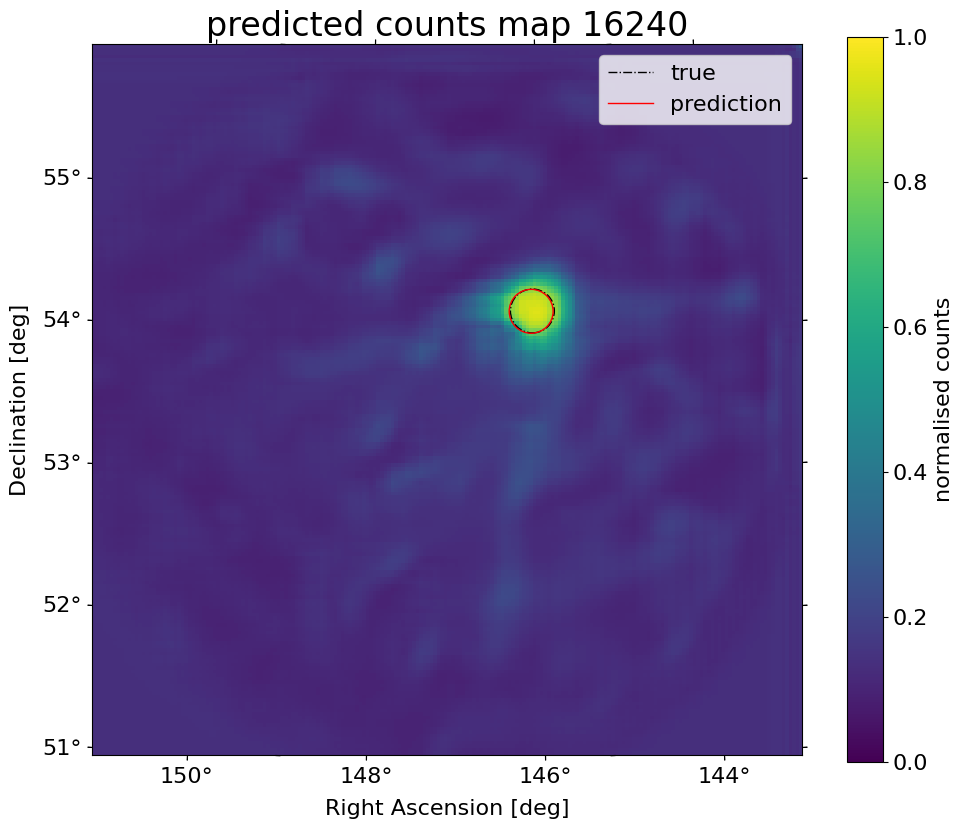

In [30]:
custom_lines = [Line2D([0], [0], color='k', lw=1, ls='-.'),
                Line2D([0], [0], color='r', lw=1, ls='-')]

# PIX
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.imshow(ds[idx], vmin=0, vmax=1)
ax.add_patch(plt.Circle((true_pix), radius=radius_pix, edgecolor='k', facecolor='none', ls='-.'))
ax.add_patch(plt.Circle((pred_pix), radius=radius_pix, edgecolor='r', facecolor='none', ls='-'))
ax.set_ylabel('y [pixels]', fontsize=fs)
ax.set_xlabel('x [pixels]', fontsize=fs)
ax.set_title(f'simulated counts map {seed}', fontsize=fs*1.5)

cb = fig.colorbar(img, ax=ax, shrink=0.75)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)
ax.legend(custom_lines, ['true', 'prediction'], fontsize=fs)

plt.tight_layout()
plt.show()

# SKY
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=w)
ax.imshow(predictions[idx], vmin=0, vmax=1)
ax.scatter(true_sky[0], true_sky[1], transform=ax.get_transform('icrs'), s=1e3,
           edgecolor='k', facecolor='none', ls='-.')
ax.scatter(pred_sky[0], pred_sky[1], transform=ax.get_transform('icrs'), s=1e3,
           edgecolor='r', facecolor='none', ls='-')
ax.set_ylabel('Declination [deg]', fontsize=fs)
ax.set_xlabel('Right Ascension [deg]', fontsize=fs)
ax.set_title(f'predicted counts map {seed}', fontsize=fs*1.5)
ax.coords['ra'].set_format_unit(u.deg)
ax.coords['dec'].set_format_unit(u.deg)

cb = fig.colorbar(img, ax=ax, shrink=0.8)
ax.tick_params(axis='both', labelsize=fs)
cb.ax.tick_params(labelsize=fs)
cb.set_label('normalised counts', fontsize=fs)
ax.legend(custom_lines, ['true', 'prediction'], fontsize=fs)

plt.tight_layout()
plt.show()

In [31]:
# save plot
fig.savefig(f'img/heatmap_{seed}_pix.png')
fig.savefig(f'img/heatmap_{seed}_sky.png')